К текущему моменту мы научились обучать простейшую линейную регрессию: причем научились пользоваться как готовыми методами из sklearn, так и реализовывать поиск решения оптимальных коэффициентов самостоятельно с помощью градиентного спуска.

На последних занятиях мы узнали, что на практике часто приходится прибегать к некоторым хитростям, чтобы оценить, действительно ли модель отлично справляется со своей главной задачей - делать хорошие предсказания на новых данных в будущем, или, как еще говорят, в проде - после запуска.

Для этого было введено понятие так называемой обобщающей способности модели. Оно помогает нам оценить, насколько наша модель подогналась под увиденные данные и насколько она окажется хороша на новых данных.

Обобщающую способность мы научились оценивать с помощью метода Кросс-Валидации.

<div>
<img src="https://disk.yandex.ru/i/Z4AhAOoj3BbZpgg" width="400"/>
</div>



Построим для старой задачи с предсказанием длительности поездки в такси 2 модели линейной регрессии. Для каждой из них замерим качество на кросс-валидации и на тесте, заранее его отложив.

Считается, что если для K-Fold Кросс-Валидации брать большие значения K (то есть большое количество сплитов для разбиения тренировочной выборки на тренировку-валидацию), то оценка среднеквадратической ошибки будет получаться более справедливой. Так, например, когда K оказывается максимальным, а именно равным количеству объектов в выборке (каждый раз в валидации у нас 1 новый объект), то такой метод Кросс-Валидации еще называют LeaveOneOut.

Главная причина, почему мало где его используют, состоит в дороговизне такого метода. Например, в данной задаче в TAXI_train.csv лежит почти 1,2 млн. объектов. Тогда, чтобы замерить качество на LeaveOneOut валидации, нам пришлось бы обучить 1,2 млн. различных версий одной модели, что, конечно, не вписыватеся в рамки адекватного времени и прочих ресурсов.

Поэтому выберем компромиссное значение в виде 20 фолдов для K-Fold Кросс-Валидации.

Внимание! Для каждой из 2 моделей очевидно было бы справедливым замерять качество на тех же самых объектах, поэтому сплиты лучше зафиксировать сразу.

P.S. Оптимизировать будем MSLE метрику. И сравнивать модели тоже будем по ней будем. Как из домашнего задания про метрики, только без корня! :)

$$\text{MSLE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2$$


### Модель №1 Для начала посчитаем ошибку на Кросс-Валидации и Тесте для нашей самой базовой модели до вычленения каких-либо признаков, а просто взяв все вещественные колонки.

In [120]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [121]:
initial_data = pd.read_csv('initial_data.csv', index_col='id')

initial_cols = ['vendor_id', 'passenger_count', 'pickup_longitude',
                 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                'trip_duration']

initial_data = initial_data[initial_cols]

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trip_duration', ylabel='Density'>

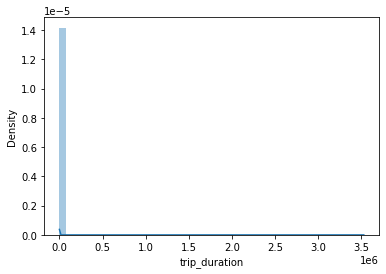

In [122]:
sns.distplot(initial_data['trip_duration'])

In [123]:
initial_data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
id,,,,,,,
id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,455.0
id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,663.0
id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,2124.0
id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,429.0
id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,435.0


### ТрюК!

In [124]:
### Замерять будем MSLE. Можно показать, что для оптимизации MSLE,
### Достаточно логарифмировать таргетную переменную, 
### а потом оптимизировать привычные MSE
import numpy as np

initial_data = initial_data.assign(log_trip_duration=np.log1p(initial_data['trip_duration']))
initial_data = initial_data.drop('trip_duration', axis=1)

### Объяснение:

Пусть имеем модель $a(x)$, обученную на MSE от $y$:
$$
\text{MSE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(y_i - a(x_i)\big)^2 \rightarrow min
$$

Также представим модель $a^*(x)$, обученную на MSE от $\log{(y + 1)}$:
$$
\text{MSE}(X, \log{(y+1)}, a^*) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - a^*(x_i)\big)^2 \rightarrow min
$$

Так как вторая модель старается аппроксимироваться ответы в виде $a^*(x) \approx \log{(y+1)}$, то для того, чтобы получить изначальные таргеты, необходимо выходы $a^*(x)$ проэкспоненцировать в виде следующего отношения: $a(x) = e^{a^*(x)} - 1$, то есть $a^*(x) = \log{(a(x) + 1)}$, где $a^*(x)$ дает логарифмические выходы, а $a(x)$ - изначальные. Подставим данное соотношение в MSE выше, получим:

$$
\text{MSE}(X, \log{(y+1)}, \log{(a(x) + 1)}) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$

А это в точности MSLE от $y$:

$$
\text{MSLE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$

почему мы выбрали MLSE - потому что у нас слишком много выбросов в таргете, и мы хотели бы все свети к регрессии на порядках,а не регресии на абсолютных числах

In [125]:
### Выделим test

from sklearn.model_selection import train_test_split

X = initial_data.drop('log_trip_duration', axis=1)
y = initial_data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_trip_duration', ylabel='Density'>

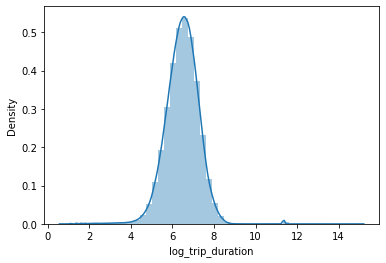

In [126]:
sns.distplot(y)

In [78]:
### Применим K-Fold на оставшуюяся валидационную часть X_train, y_train

from sklearn.model_selection import KFold

splitter = KFold(n_splits=20, shuffle=True, random_state=33)

$$
\text{MSLE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$

In [44]:
losses_test = []
losses_train = []

for train_index, test_index in splitter.split(X_train):
    X_train, X_test = X.values[train_index], X.values[test_index]
    Y_train, Y_test = y.values[train_index], y.values[test_index]
    
    model = LinearRegression()
    model.fit(X_train, Y_train)
    
    loss_test = np.mean((model.predict(X_test)-Y_test)**2)
    loss_train = np.mean((model.predict(X_train)-Y_train)**2)
    
    losses_test.append(loss_test**(1/2))
    losses_train.append(loss_train**(1/2))

In [47]:
np.mean(losses_train), np.mean(losses_test)

(0.7789102057390467, 0.7912157666974509)

In [79]:
model = LinearRegression()

In [80]:
scores = cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv = splitter)

In [81]:
np.mean(abs(scores))

0.6134219105328516

In [6]:
### Замерьте качество на кросс-валидации!
### Your code is here

In [18]:
### Теперь построим модель на всей тренировочной выборке
### и замерим качество на тесте!
### Your code is here

In [84]:
model.fit(X_train, y_train)
np.mean((model.predict(X_test) - y_test)**2)

0.6056668879526319

In [ ]:
### Укажите в ответе на задание 4 среднее качество моделей на валидационных выборках
### и качество модели, обученной на полной тренировочной выборке, на тестовой выборке.
### В качестве разделителя используйте точку, ответ округлите до тысячных.

### Модель №2. Проделаем все то же самое, только для модели с более осознанными признаками, которые удалось получить ранее

In [94]:
processed_data = pd.read_csv('processed_data.csv', index_col='id')

In [95]:
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance_km
id,,,,,
id2875421,1,930.399753,0,455.0,1.500479
id2377394,0,930.399753,0,663.0,1.807119
id3858529,1,930.399753,0,2124.0,6.392080
id3504673,1,930.399753,0,429.0,1.487155
id2181028,1,930.399753,0,435.0,1.189925


In [96]:
### Замерять будем MSLE. Можно показать, что для оптимизации MSLE,
### Достаточно логарифмировать таргетную переменную, 
### а потом оптимизировать привычные MSE
import numpy as np

processed_data = processed_data.assign(log_trip_duration=np.log1p(processed_data['trip_duration']))
processed_data = processed_data.drop('trip_duration', axis=1)

In [97]:
X_2 = processed_data.drop('log_trip_duration', axis=1)
y_2 = processed_data['log_trip_duration']

In [100]:
### Важно! Когда сравниваем модели по их качеству
### на валидации и на тесте, не шаффлим данные заново!

test_indexes = X_test.index
train_indexes = X_train.index

In [106]:
X_train_2 = X_2[X_2.index.isin(train_indexes)]#взяли те строки,котор имеют индекс train_indexes, на выходе - датафрейм
y_train_2 = y_2[y_2.index.isin(train_indexes)]

X_test_2 = X_2[X_2.index.isin(test_indexes)]
y_test_2 = y_2[y_2.index.isin(test_indexes)]

In [107]:
X_train_2

,vendor_id,passenger_count,store_and_fwd_flag,distance_km
id,,,,
id2875421,1,930.399753,0,1.500479
id2377394,0,930.399753,0,1.807119
id3858529,1,930.399753,0,6.392080
id3504673,1,930.399753,0,1.487155
id2181028,1,930.399753,0,1.189925
...,...,...,...,...
id1454193,1,1070.232174,0,2.320055
id2376096,1,1053.529749,0,1.226296
id1049543,0,930.399753,0,6.056935


In [28]:
### Замерьте качество на кросс-валидации!
### Your code is here

In [108]:
scores2 = cross_val_score(model, X_train_2, y_train_2, scoring = 'neg_mean_squared_error', cv = splitter)

In [109]:
np.mean(abs(scores2))

0.4313257704232941

In [6]:
### Теперь построим модель и замерим качество на тесте!
### Your code is here

In [110]:
model2 = LinearRegression().fit(X_train_2, y_train_2)

In [111]:
np.mean((model2.predict(X_test_2) - y_test_2)**2)

0.40746695468102967

In [ ]:
### Укажите в ответе на задание 5 среднее качество моделей на валидационных выборках
### и качество модели, обученной на полной тренировочной выборке, на тестовой выборке.
### В качестве разделителя используйте точку, ответ округлите до тысячных.

### Какую модель среди двух стоило бы выбрать? Помогла ли нам базовая обработка признаков с первых уроков? 

Да, помогла. Модель с более осознанными признаками показывает качество лучше.